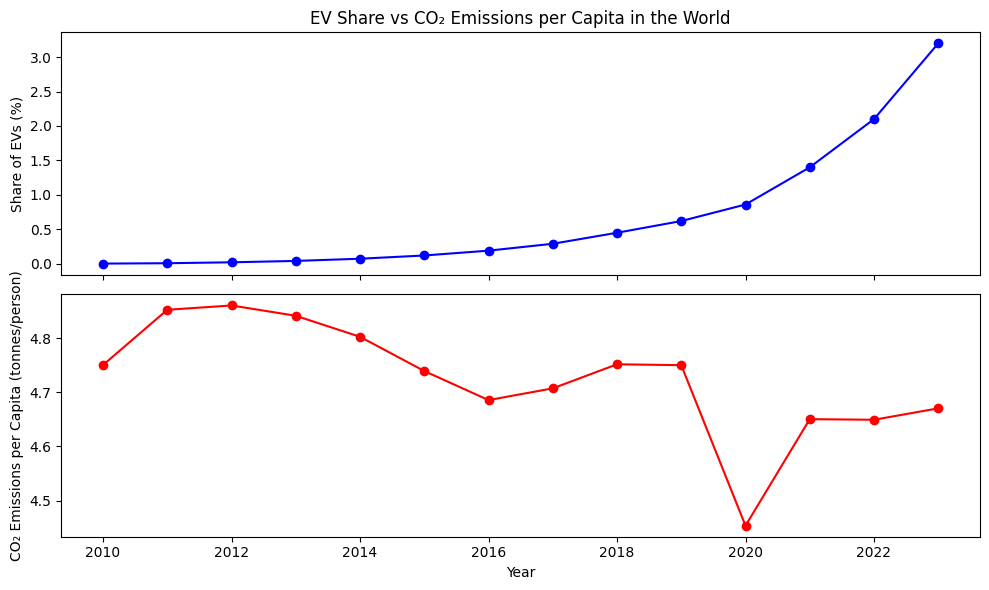

In [22]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np  
import wbgapi as wb
import zipfile
import io
import matplotlib.pyplot as plt
import plotly.express as px
import os

url='https://api.iea.org/evs?parameters=EV%20stock%20share&category=Historical&mode=Cars&csv=true'
response = requests.get(url)
evshare_df = pd.read_csv(url)

co2_df = pd.read_csv("https://ourworldindata.org/grapher/co-emissions-per-capita.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
metadata = requests.get("https://ourworldindata.org/grapher/co-emissions-per-capita.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

#Filter the data for EV stock share
evstock_filter = evshare_df['parameter'] == 'EV stock share'
ev_filter = evshare_df['powertrain'] == 'EV'
evshare_filtered = evshare_df[evstock_filter & ev_filter]

#Clean the data
evshare_filtered = evshare_filtered.dropna()
evshare_filtered = evshare_filtered.drop(columns=["mode", "unit", "category", "parameter", "powertrain"])
co2_df = co2_df.dropna()
co2_df = co2_df.drop(columns=["Code"])

#Rename columns
evshare_filtered = evshare_filtered.rename(columns={
    'region': 'Entity',
    'year': 'Year',
    'value': 'Share of EVs (%)',
})
co2_df = co2_df.rename(columns={
    'Entity': 'Entity',
    'Year': 'Year',
    'emissions_total_per_capita': 'CO2 Emissions per Capita (tonnes/person)',
})

#Indexing and renaming columns
evshare_index = evshare_filtered.set_index(['Entity', 'Year'])
co2_index = co2_df.set_index(['Entity', 'Year'])

# Merge the two dataframes on Entity and Year
merged_df = evshare_index.merge(co2_index, on=['Entity', 'Year'], how='inner')

# Reset index to make it easier to work with
merged_df = merged_df.reset_index()

# Save the merged dataframe to a CSV file
merged_df.to_csv('ev_co2_data.csv', index=False)

# Plotting the data
country = 'World'
df_country = merged_df[merged_df['Entity'] == country]

# Extract time series
years = df_country['Year']
ev_share = df_country['Share of EVs (%)']
ghg_emissions = df_country['CO2 Emissions per Capita (tonnes/person)']

# Plot as stacked subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(years, ev_share, color='blue', marker='o')
ax1.set_ylabel('Share of EVs (%)')
ax1.set_title(f'EV Share vs CO₂ Emissions per Capita in the {country}')

ax2.plot(years, ghg_emissions, color='red', marker='o')
ax2.set_ylabel('CO₂ Emissions per Capita (tonnes/person)')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

In [23]:
country_corrs = (
    merged_df.groupby('Entity')
    .apply(lambda group: group['Share of EVs (%)'].corr(group['CO2 Emissions per Capita (tonnes/person)']))
    .dropna()
)

# Show top positive/negative correlations
print(country_corrs.sort_values(ascending=False).head(10))  # strong positive correlation
print(country_corrs.sort_values().head(10))  # strong negative correlation


Entity
China         0.875283
Indonesia     0.782649
Russia        0.773919
India         0.706080
Malaysia      0.491752
Colombia      0.163324
Costa Rica    0.129989
Thailand     -0.216224
Brazil       -0.294626
World        -0.495474
dtype: float64
Entity
Norway         -0.968826
Netherlands    -0.950662
South Africa   -0.941999
New Zealand    -0.938836
Japan          -0.904656
Portugal       -0.871799
Germany        -0.863754
Canada         -0.857907
Austria        -0.856667
Switzerland    -0.839133
dtype: float64


/Users/kdaseo/Documents/GitHub/graspp-25S-AI_Energy/cleanenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/kdaseo/Documents/GitHub/graspp-25S-AI_Energy/cleanenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning:

divide by zero encountered in divide

/Users/kdaseo/Documents/GitHub/graspp-25S-AI_Energy/cleanenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning:

invalid value encountered in multiply

/var/folders/h4/3_55q33x6b11nb035d580hrm0000gn/T/ipykernel_25259/420674978.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [31]:
import numpy as np

x = merged_df['Share of EVs (%)'].values
y = merged_df['CO2 Emissions per Capita (tonnes/person)'].values

# Fit a linear model
slope, intercept = np.polyfit(x, y, 1)
print("Intercept:", intercept)
print("Slope:", slope)


Intercept: 6.805497239120511
Slope: 0.01830257822631245
